In [2]:
from properties import LYRICS_ROOT_FOLDER
from pathlib import Path
from fuzzywuzzy import fuzz
from datetime import datetime
from utils import create_connection, execute_script, find_first, song_filter_id
from models.Song import Song
from models.SongStructure import SongStructure
from models.Section import Section
import logging
import csv
import re
import json
import pandas as pd
import os
import numpy as np

SONG_PROCESSING_FOLDER = LYRICS_ROOT_FOLDER / "extraction"

# 1. Parse lyrics.jl with help of artist_info.json

In the lyrics.jl file, each line looks like this 

```json
{"song": "Kendrick-lamar-swimming-pools-drank-lyrics", "lyrics": " ... "}
```

We want to parse the song name as provided in this file into (1) artist and (2) song title.

In artist_info.json, we have 
```json
{
  "url_name": "Kendrick-lamar",
  "followers": 23782,
  "roles": [
    "Verified Artist",
    "Contributor"
  ],
  "iq": 39144,
  "songs": [
    "Kendrick-lamar-humble-lyrics",
    "A-ap-rocky-fuckin-problems-lyrics",
    "Kendrick-lamar-maad-city-lyrics",
    "Kendrick-lamar-swimming-pools-drank-lyrics",
    "..."
  ]
}
```

So ideally, we want to recognize that the artist of the song is "Kendrick Lamar", and the song title is "Humble". And we can do so by crossreferencing lyrics.jl with artist_info.json.

Another strategy is that, of the songs of which this mapping fails, we extract the longest common prefix from the song url (the "song" attribute of lyrics.jl) and we can then say with some confidence that this will be the artist name, since we know that the url starts with the artist name.

In [ ]:
artist_names : list[str] = [] # listing all the distinct artist names from artist_info 
with open(Path(LYRICS_ROOT_FOLDER, "artist_info.json"), 'r') as artist_info:
    while (line := artist_info.readline()):
        data = json.loads(line)
        artist = data['url_name']

        if artist in artist_names:
            continue
    
        artist_names.append(artist)


# buckets of artist name per first char (lowercase)
# buckets are sorted lengthwise (longest first) to make greedy artist name matching faster
first_chars = set(map(lambda name: name[0].lower(), artist_names))
processed_artist_names = {first_char : sorted([artist_name for artist_name in artist_names if artist_name.lower().startswith(first_char)], key=len, reverse=True) for first_char in first_chars}

# Now we crossreference lyrics.jl lines with these artists to the best of our ability
songs : list[Song] = []
not_found_artists : list[str] = []
disregarded_songs : list[str] = []

with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        _song_info = data['song']

        # There are also "annotations" in the lyrics.jl file but we're not interested in them.
        if not _song_info.endswith('lyrics'): 
            disregarded_songs.append(_song_info)
            continue

        # infer the artist name by taking a look whether there is an exact match with one of the artists in the appropriate bucket
        artist_bucket_to_search = processed_artist_names[_song_info[0].lower()]
        matched_artist = find_first(lambda artist_name: _song_info.startswith(artist_name), artist_bucket_to_search)

        if matched_artist is None:
            not_found_artists.append(_song_info)
            continue

        # extract song title from the song info (given that we now know the artist name):
        # example: " ".join('artist-name-this-is-the-song-title-lyrics'.split('artist-name')[1].split('-')[1:-1]).strip() -> "this is the song title"
        title = " ".join(_song_info.split(matched_artist)[1].split('-')[1:-1]).strip()
        songs.append(Song(_song_info, title, matched_artist.replace('-', " ").strip(), data['lyrics']))

print(f"Infered song data for {len(songs)} songs")
if len(not_found_artists) > 0:
    print(f"Failed for {len(not_found_artists)} due to artist mapping not found")
assert len(list(filter(lambda info: not info.endswith('annotated'), disregarded_songs))) == 0, "All disregarded songs should be annotations"
if len(disregarded_songs) > 0:
    print(f"Disregarded {len(disregarded_songs)} entries (annotations)")

KeyboardInterrupt: 

In [ ]:
# Strategy to infer new arists names: extract the longest common prefix of the  song (that will be the artist probably)

# 1. bucket per first char again to make the process easier (again, also sorted by length -- largest first)
not_found_first_chars = set(map(lambda name: name[0].lower(), not_found_artists))
not_found_artists_bucketed = {first_char : sorted([artist_name for artist_name in not_found_artists if artist_name.lower().startswith(first_char)], key=len, reverse=True) for first_char in not_found_first_chars}
artist_still_not_found : list[str] = []

matches = {}
extracted_artists = set()

for info in not_found_artists:

    # Maybe we have already processed the artist
    match = find_first(lambda x: info.replace('-', " ").strip().startswith(x), sorted(extracted_artists, key=len, reverse=True))
    if match is not None:
        matches[info] = match
        continue
    
    bucket_longest_first = sorted(not_found_artists_bucketed[info.lower()[0]], key=len, reverse=True)
    
    bucket_size = len(bucket_longest_first)
    # We cannot leverage other songs to guess the artist, because this is the only one in there
    if bucket_size == 1:
        artist_still_not_found.append(info)
        continue

    # Check matches with others and assign a confidence score (percentage)
    others = bucket_longest_first
    others.remove(info)
    others_ranked = {other : 0 for other in others}
    for other in others:
        word_pairs = zip(info.split('-'), other.split('-'))
        for info_word, other_word in word_pairs:
            if info_word != other_word:
                break
            others_ranked[other] += 1
            
    ## Now we sort by ranked and see how much they have in common
    largest_common_prefix_word_count = max(others_ranked.values())
    others_matching = list(filter(lambda x: others_ranked[x] == largest_common_prefix_word_count, others))
    # Now we assign the artist to these songs
    resolved_artist_name = " ".join(info.split('-')[:largest_common_prefix_word_count]).strip()
    matches[info] = resolved_artist_name
# Show the found artists
reversed_matches = {}
for song, artist in matches.items():
    if artist not in reversed_matches.keys():
        reversed_matches[artist] = []
    reversed_matches[artist].append(song)

for artist in sorted(reversed_matches.keys()):
    print(artist)
    for song in reversed_matches[artist]:
        print('\t', song)

new_songs : list[Song] = []
# Update the data with the custom found
with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        song_info = data['song']
        if song_info not in matches.keys() or matches[song_info] == '':
            continue
        artist = matches[song_info]
        title = " ".join(song_info.split(artist.replace(" ", "-"))[1].split('-')[1:-1]).strip()
        new_songs.append(Song(song_info, title, artist.replace('-', " ").strip(), data['lyrics']))

print(f"Added {len(new_songs)} new songs")
all_songs = songs + new_songs


	 Caye-easy-lyrics
	 Trav-fuck-and-smoke-lyrics
	 Amil-4-da-fam-lyrics
	 B-smyth-leggo-lyrics
	 Chevralet-ss-bad-mother-fucker-bmf-lyrics
	 Cb4-straight-outta-locash-lyrics
	 Terra-g-clock-work-lyrics
	 Quincy-exotic-lyrics
	 Quin-over-again-lyrics
	 Koryn-hawthorne-bright-fire-lyrics
	 Acid-drop-king-im-a-problem-lyrics
	 Kda-just-say-lyrics
	 Trey-smith-find-you-somewhere-lyrics
	 Bwa-ron-all-i-ever-wanted-lyrics
	 Ambre-preach-lyrics
	 Artistes-divers-vald-sofiane-kalash-criminel-biffty-et-suikon-blaze-ad-en-live-dans-planete-rap-lyrics
	 Catch-lungs-gotta-kill-this-lyrics
	 Fedy-only-thing-i-know-lyrics
	 Batgang-dangerous-lyrics
	 Tamia-officially-missing-you-midi-mafia-mix-with-rap-lyrics
	 Kold-i-love-the-holy-grail-lyrics
	 Tamar-braxton-the-one-lyrics
	 Tracey-lee-keep-your-hands-high-lyrics
	 Cashflow-harlem-want-my-love-back-lyrics
	 A1billionaire-rookie-of-the-year-lyrics
	 Louis-mattrs-oops-x-wus-good-lyrics
	 T-la-rock-and-jazzy-jay-its-yours-lyrics
	 Bando-jonez-sex-you

# TODO

- Check how many songs are left without artists 
- Check the artists
    - Bruno Mars
- Check the labels (other languages?)
- Check label generation (greedy does not work, we need the first occurence)
    - Section repeat indicators ("\[Hook\] -2X" in Da ruckus - We shine)
    - Some songs have "illegal" or excessive brackets in them

In [8]:
# Write the songs to a csv file:
with open(Path(SONG_PROCESSING_FOLDER, "lyrics_tracks.tsv"), 'w') as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["track_id", "artist_name", "track_name", "genius_url"])
    for song in all_songs:
        writer.writerow([song.id, song.artist, song.title, song.genius_url])


# 2. Crossreference the data
## How to link the LFM2B dataset to this extracted data?

We have extracted song artists and titles for which we have the lyrics available from lyrics.jl.
These are now neatly written to a tsv file where each song also has an ID. 

So, the idea is to create a new file in which we link tracks by their ID in the LFM2B dataset and their ID in the genius lyrics dataset. 

The matching process is inherently inprecise, as tracks might not all be represented in the same way in both datasets. 
Therefore, we do "fuzzy matching" per song on both the artist as well as the track name. 

So each song from the genius lyrics database (GLDB) matches to zero or more artists in LFM2B and to zero or more track names in LFM2B. 

Then we will assign a confidence score for the artist and for the track name using a fuzzy matching library `fuzzywuzzy`. This yields a score \[0-100\] (percentage overlap; capitalization ignored).

We simply rank the matches on their score (highest score = rank 1).



In [ ]:
# We only consider the tracks where we could have lyrics (non-instrumental)

con, cursor = create_connection("lfm2b")
cursor.execute(r"create materialized view if not exists track_non_instrumental as select * from track where track_name not ilike '%instrumental%';")
cursor.execute("""create materialized view if not exists le_non_instrumental as 
                    select le.* from listening_event le where exists 
                    (select 1 from track_non_instrumental tni where tni.track_id = le.track_id)"""
               )

class LFM2BMatch:
    def __init__(
        self,
        song,
        lfm2b_artist_id,
        lfm2b_artist_name,
        artist_confidence,
        lfm2b_track_id,
        lfm2b_track_name,
        track_confidence,
    ):
        self.song = song
        self.lfm2b_artist_id = lfm2b_artist_id
        self.lfm2b_artist_name = lfm2b_artist_name
        self.lfm2b_track_id = lfm2b_track_id
        self.lfm2b_track_name = lfm2b_track_name
        self.artist_confidence = artist_confidence
        self.track_confidence = track_confidence

    def __repr__(self):
        return f"{self.lfm2b_artist_name} - {self.lfm2b_track_name}"


matches: list[LFM2BMatch] = []
non_matched: list[Song] = []
errors: list[tuple[Song, Exception]] = []


def setup_logger():
    # We need to remove the handler so that the logs will not be written to the cell's output.
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    timestamp = datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
    MAPPING_LOG_PATH = Path(
        SONG_PROCESSING_FOLDER, f"lfm2b-genius-mapping_{timestamp}.log"
    )
    logging.basicConfig(
        filename=MAPPING_LOG_PATH,
        level=logging.INFO,
        datefmt="%d-%m-%Y,%H:%M:%S",
        format="%(levelname)s - %(asctime)s: %(message)s",
        encoding="utf8",
    )
    return logging.getLogger()


def similarity_score(a: str, b: str) -> int:
    """Return a score [0-100] on how similar `a` is to `b`"""
    return fuzz.ratio(a.lower(), b.lower())


def find_best_track_match(
    song: Song, artists: list, tracks: list, write_function, logger
) -> LFM2BMatch | None:
    """Extracts the best match according to the procedure descibred in the above cell.
    Given a song (GLDB), matched artists (LFM2B) and matched tracks (LFM2B), ranks the matches and returns the best ranked match if possible.
    If no artists are matched in the first place, then no match can be made, so `None` is returned.

    Matches are directly written with the `write_function` and the process is logged to file.
    """

    # Create the ranking

    artist_name_ranking = []
    for artist_id, artist_name in artists:
        artist_name_ranking.append(
            (
                song.artist,
                artist_id,
                artist_name,
                similarity_score(song.artist, artist_name),
            )
        )

    track_name_ranking = []
    for track_id, track_name, artist_id, artist_name in tracks:
        track_name_ranking.append(
            (
                song.title,
                track_id,
                track_name,
                artist_id,
                artist_name,
                similarity_score(song.title, track_name),
            )
        )

    artist_name_ranking.sort(key=lambda x: x[3], reverse=True)
    track_name_ranking.sort(key=lambda x: x[5], reverse=True)

    LIMIT = 10  # limit the amount of logged rankings for file size purposes
    logger.info("\t artist ranking")
    for artist_ranking in artist_name_ranking[:LIMIT]:
        logger.info("\t\t %s", artist_ranking)

    logger.info("\t track ranking")
    for track_ranking in track_name_ranking[:LIMIT]:
        logger.info("\t\t %s", track_ranking)

    logger.info("\t verdict")

    best_match: LFM2BMatch | None = (
        None  # We assume no match (for example if there are no eligible tracks)
    )

    # Ideally, we have the best ranked track (name) with the highest best ranked artist name
    if len(track_name_ranking) > 0 and len(artist_name_ranking) > 0:
        for ranked_track in track_name_ranking:
            for ranked_artist in artist_name_ranking:
                if ranked_track[3] == ranked_artist[1]:
                    best_match = LFM2BMatch(
                        song,
                        lfm2b_artist_id=ranked_artist[1],
                        lfm2b_artist_name=ranked_artist[2],
                        artist_confidence=ranked_artist[-1],
                        lfm2b_track_id=ranked_track[1],
                        lfm2b_track_name=ranked_track[2],
                        track_confidence=ranked_track[-1],
                    )
                    break
    elif len(track_name_ranking) > 0:
        best_ranked_track = track_ranking[0]
        # We have only track information, so just get the best track
        best_match = LFM2BMatch(
            song,
            lfm2b_artist_id=best_ranked_track[3],
            lfm2b_artist_name=best_ranked_track[4],
            artist_confidence=0,
            lfm2b_track_id=best_ranked_track[1],
            lfm2b_track_name=best_ranked_track[2],
            track_confidence=best_ranked_track[-1],
        )

    logger.info("\t\t %s", best_match)
    write_function(
        best_match
    )  # write the match to file, note that an exception will be raised when there is no match found (None). This is caught in the error logfile on purpose.


# Here we define bounds for the matching process
# It is a very long process, so it is nice to be able to split it up into chuncks. If START SONG <= END_SOND, this cell will not run but raise an exception.
START_SONG_ID = 0
END_SONG_ID = 0
last_song_id = None


def do_song_mapping(songs, cursor, logger):
    """This is the process of mapping the songs. It is made into a function purely because it can then be easily commented out after all processing is done."""
    global last_song_id
    start = songs[0].id
    end = songs[-1].id
    with open(SONG_PROCESSING_FOLDER / f"errors_{start}-{end}.tsv", "w") as error_file:
        error_file.write("track_id\ttrack\terror\n")
        mapping_path = Path(
            SONG_PROCESSING_FOLDER, f"lfm2b_genius_track_mapping_{start}-{end}.tsv"
        )
        assert (
            not mapping_path.exists()
        ), f"WARNING. You are about to overwrite this file {mapping_path}"

        with open(mapping_path, "w", encoding="utf8") as f:
            writer = csv.writer(f, delimiter="\t")
            writer.writerow(
                [
                    "lfm2b_track_id",
                    "genius_lyrics_track_id",
                    "artist_confidence",
                    "track_confidence",
                ]
            )
            write_function = lambda match: writer.writerow(
                [
                    match.lfm2b_track_id,
                    match.song.id,
                    match.artist_confidence,
                    match.track_confidence,
                ]
            )
            for song in songs:
                try:
                    last_song_id = song.id
                    logger.info(
                        "Computing match for song %d: %s - %s",
                        song.id,
                        song.artist,
                        song.title,
                    )

                    if song.title.strip() == "" or song.artist.strip() == "":
                        logger.info("\tSkipping due to empty title or artist")
                        raise RuntimeError(
                            "Empty song artist or title"
                        )  # To collect this in the error_file, we raise exception

                    cursor.execute(
                        f"SELECT artist_id, artist_name FROM artist WHERE artist_name ilike '%{song.artist}%'"
                    )
                    artists = cursor.fetchall()
                    cursor.execute(
                        f"SELECT track_id, track_name, artist_id, artist_name FROM track_non_instrumental NATURAL JOIN artist WHERE track_name ilike '%{song.title}%'"
                    )
                    tracks = cursor.fetchall()

                    if len(tracks) == 0:
                        logger.warning("\t No matches for this track, skipping...")

                    _ = find_best_track_match(song, artists, tracks, write_function, logger)
                except Exception as e:
                    error_file.write(f"{song.id}\t{song}\t{e}\n")
                    errors.append((song, e))


if (END_SONG_ID - START_SONG_ID) <= 0:
    con.close()
    raise RuntimeError("No songs selected for mapping")

logger = setup_logger()
songs_to_map = filter(
    lambda s: (s.id >= START_SONG_ID and s.id <= END_SONG_ID), all_songs
)
do_song_mapping(songs_to_map, cursor, logger)
con.close()

print(f"Had {len(errors)} errors")
print(f"Last song id {last_song_id}")  # Useful for monitoring the process.

DuplicateColumn: column "track_id" specified more than once


## Fixing failed mappings

To see which tracks failed, we categorize them:

1. Loop through all the "error" csv files and group on 'error' column
2. Loop trough all the track mappings and see whether the mappings are valid (integer keys for example)

We collect those songs for which the mapping failed and we go through them again if needed

In [9]:
def find_files_in_folder_matching_to(folder, pattern):
    return list(filter(lambda fn : bool(re.match(pattern, fn)), os.listdir(folder))) 


error_files = find_files_in_folder_matching_to(SONG_PROCESSING_FOLDER, r"errors_\d+-\d+.tsv") 
error_files.sort(key=lambda fname: int(fname[7:-4].split('-')[0]))

errors = {}
for error_file in error_files:
    with open(SONG_PROCESSING_FOLDER / error_file, "r") as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader) # skip headers
        for line in reader:
            if line == []:
                continue
            track_id, _, err = line
            if err not in errors.keys():
                errors[err] = []
            errors[err].append(track_id)

for err, song_ids in errors.items():
    print(f"{err}: {len(song_ids)}")

'NoneType' object has no attribute 'lfm2b_track_id': 9569
string index out of range: 673
Empty song artist or title: 32
Cannot operate on a closed database.: 1
: 2


In [10]:
class DuplicateException(RuntimeError):
    """ Class to signify duplicate mappings """
    def __init__(self, *args):
        super().__init__(*args)

lfm2b_to_genius = dict()
# These dictionaries are these for monitoring purposes
map_errs : dict[RuntimeError, list[int]]= dict() # For tracking failed mappings that ended up in the tsv files. Grouped per error type
id_seen_in_files : dict[int, list[str]] = dict() # For tracking duplicate GENIUS ids (they may end up in multiple files due to the fragmented mapping process of start/end ID)

mapping_files = find_files_in_folder_matching_to(SONG_PROCESSING_FOLDER, r"lfm2b_genius_track_mapping_\d+-\d+.tsv")
for track_mapping in mapping_files: 
    with open(SONG_PROCESSING_FOLDER / track_mapping) as lyrics_tracks_mapping:
        reader = csv.reader(lyrics_tracks_mapping, delimiter='\t')
        next(reader) # skip headers
        for line in reader:
            if line == []: # Might be empty lines in between records due to the way they were logged
                continue
            try:
                lfm2b_track_id, genius_track_id, artist_confidence, track_confidence = line
                
                lfm2b_track_id_int = int(lfm2b_track_id)
                genius_track_id_int = int(genius_track_id)
                artist_confidence_int = int(artist_confidence)
                track_confidence_int = int(track_confidence)

                if genius_track_id not in id_seen_in_files.keys():
                    id_seen_in_files[genius_track_id] = []

                id_seen_in_files[genius_track_id].append(lyrics_tracks_mapping.name)

                # It can happen that multiple Genius songs map to the same LFM2b song according to the fuzzy matching...
                # In that case, we need to investigate which song fits better...
                if lfm2b_track_id_int in lfm2b_to_genius.keys():
                    (old_mapping, old_ac, old_tc, old_file) = lfm2b_to_genius[lfm2b_track_id_int]
                    print(f"WARNING! Duplicate mapping found to LFM2B track {lfm2b_track_id_int}:\n\tgenius track {old_mapping} ({old_ac}, {old_tc}) from {old_file}\n\tgenius track {genius_track_id_int} ({artist_confidence}, {track_confidence}) from {track_mapping}")
                    old_score = old_ac + old_tc
                    new_score = artist_confidence_int + track_confidence_int
                    if old_mapping == genius_track_id or old_score > new_score:
                        # No overwrite when we have a duplicate mapping
                        continue

                    # We are overwriting the old mapping, so we better record this explicitly to handle it later
                    print(f"\toverwriting due to better total score... ({new_score} vs {old_score})")
                    if DuplicateException not in map_errs.keys():
                        map_errs[DuplicateException] = []
                    map_errs[DuplicateException].append(old_mapping)
                    

                lfm2b_to_genius[lfm2b_track_id_int] = (genius_track_id_int, artist_confidence_int, track_confidence_int, track_mapping)
                

            except Exception as e:
                tp = type(e)
                if tp not in map_errs.keys():
                    map_errs[tp] = []
                map_errs[tp].append(int(genius_track_id))

print(f"{len(lfm2b_to_genius.keys())} successful mapping")
print(f"{len(map_errs.keys())} error types: {map_errs.keys()}")
for id, files in id_seen_in_files.items():
    if len(files) > 1:
        print(f"Saw {id} in files {files}")

def song_id_in_filter(id_list):
    return lambda song : song.id in id_list

failed_maps = set(err for failed_per_error in map_errs.values() for err in failed_per_error) # flattens all errors, regardless of err type
failed_songs = set(filter(song_id_in_filter(failed_maps), all_songs))

assert len(failed_songs) == len(failed_maps), f"Could not map all failures to songs; failed_maps {len(failed_maps)}, failed_songs {len(failed_songs)}"

# logger = setup_logger()
# do_song_mapping(list(failed_songs), logger)

WARNING! Duplicate mapping found to LFM2B track 28982361:
	genius track 146 (100, 30) from lfm2b_genius_track_mapping_0-3000.tsv
	genius track 197 (100, 70) from lfm2b_genius_track_mapping_0-3000.tsv
	overwriting due to better total score... (170 vs 130)
WARNING! Duplicate mapping found to LFM2B track 24197188:
	genius track 427 (100, 40) from lfm2b_genius_track_mapping_0-3000.tsv
	genius track 494 (100, 18) from lfm2b_genius_track_mapping_0-3000.tsv
WARNING! Duplicate mapping found to LFM2B track 40440921:
	genius track 414 (100, 32) from lfm2b_genius_track_mapping_0-3000.tsv
	genius track 539 (100, 15) from lfm2b_genius_track_mapping_0-3000.tsv
WARNING! Duplicate mapping found to LFM2B track 4632900:
	genius track 607 (100, 29) from lfm2b_genius_track_mapping_0-3000.tsv
	genius track 639 (100, 34) from lfm2b_genius_track_mapping_0-3000.tsv
	overwriting due to better total score... (134 vs 129)
WARNING! Duplicate mapping found to LFM2B track 32629545:
	genius track 759 (100, 53) from 

In [ ]:
def create_genius_db(lfm_genius_mappings):
    con, cursor = create_connection('genius_db')
    with con: # execute in transaction
        execute_script(Path("genius_lyrics_schemas", "song.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "lfm2b_genius.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "lyrics.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "cluster.sql"), cursor) # We create it, but we do not populate it yet
        for track_id, (song_id, ac, tc, _) in lfm_genius_mappings.items():
            song = find_first(lambda s : s.id == song_id, all_songs)
            assert song is not None, f"Could not find song for this mapping! Track id {track_id}, song id {song_id}"
            assert song.id == song_id, "Just checking find_first"
            cursor.execute("""INSERT INTO song (song_id, genius_url, artist_name, song_name)
                           VALUES (%s, %s, %s, %s)
                           """, [song_id, song.genius_url, song.artist, song.title])
            cursor.execute("""INSERT INTO lfm2b_genius (track_id, song_id, artist_confidence, track_confidence)
                           VALUES (%s, %s, %s, %s)""", [track_id, song_id, ac, tc])    
            cursor.execute("""INSERT INTO lyrics (song_id, lyrics) 
                           VALUES (%s, %s)""", [song_id, song.lyrics])
    con.close()

# lfm2b_to_genius[lfm2b_track_id_int] = (genius_track_id_int, artist_confidence_int, track_confidence_int, track_mapping)
create_genius_db(lfm2b_to_genius)

NameError: name 'lfm2b_to_genius' is not defined

## What is left of the listening events?

In [7]:
gcon, gcur = create_connection("genius_db")
lfmcon, lfmcur = create_connection("lfm2b")

gcur.execute("select track_id from lfm2b_genius;")
lfm2b_track_ids = gcur.fetchall()

lfmcur.execute("select age_at_listen, count(*) from listening_event le where le.track_id in %s group by age_at_listen", (tuple(lfm2b_track_ids),))
per_age = pd.DataFrame(lfmcur.fetchall(), columns=["age_at_listen", "amt_le"])

gcon.close()
lfmcon.close()

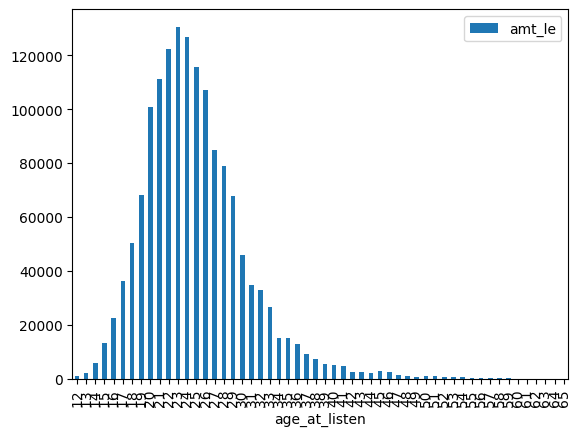

In [8]:
from properties import CSV_FOLDER

count_by_age_folder = CSV_FOLDER / "count-by-age"


per_age.plot.bar(x='age_at_listen')

per_age.to_csv(count_by_age_folder/"listening_events_count-by-age_matched_with_genius.tsv", sep='\t', index=False)


# 3. Extracting structure of the lyrics

In [35]:
# Lets load all the genius songs from the database
from utils import create_connection
conn, cursor = create_connection("genius_db")
cursor.execute("select song_id, track_id, artist_confidence, track_confidence, genius_url, song_name, artist_name, lyrics from song natural join lyrics natural join lfm2b_genius;")

class GeniusSong(Song):
    def __init__(self, song_id, track_id, artist_confidence, track_confidence, genius_url, title, artist, lyrics):
        super().__init__(genius_url, title, artist, lyrics)
        self.track_confidence = track_confidence
        self.artist_confidence = artist_confidence
        self.track_id = track_id
        self.id = song_id

genius_db_songs : list[GeniusSong] = list(map(lambda data : GeniusSong(*data),cursor.fetchall()))
conn.close()

In [36]:
LABEL_TO_SECTION : dict[str, Section]= {
        "Intro" : Section.INTRO,
        "Chorus" : Section.CHORUS,
        "Pre-Chorus" : Section.PRE_CHORUS,
        "Post-Chorus" : Section.POST_CHORUS,
        "Refrain" : Section.CHORUS,
        "Bridge" : Section.BRIDGE,
        "Verse" : Section.VERSE,
        "Outro" : Section.OUTRO,
        "Interlude" : Section.INSTRUMENTAL,
        "Hook" : Section.HOOK,
        "Pre-Hook" : Section.PRE_HOOK,
        "Post-Hook" : Section.POST_HOOK,
        "Post Hook" : Section.POST_HOOK,
        "Break" : Section.BREAK,
        "Couplet" : Section.VERSE,
        "Piano Solo" : Section.SOLO,
        "Guitar Solo" : Section.SOLO,
        "Verso" : Section.VERSE,
        "Pre-Coro" : Section.PRE_CHORUS,
        "Pont" : Section.BRIDGE,
        "Instrumental" : Section.INSTRUMENTAL,
        "Zwrotka": Section.VERSE, # Verse in Polish,
        "Refren": Section.CHORUS, # Refrain in polish,
        "Куплет": Section.VERSE, # Verse in Russian/Bulgarian...
        "Strofa": Section.VERSE, #Verse in Italian,
        "Vamp" : Section.VAMP
}

# If the brackets satisfy any of these predicates, then they will be marked ignored ("-")
IGNORES = [
    lambda x: x.lower().startswith("produced by")
]

def map_to_section(text: str) -> Section | None:
    """ Returns the corresponding section of a label. If this label is to be ignored (is not a section) according to the rules in IGNORES, then returns None, otherwise returns the Section"""
    if any([ignore_predicate(text) for ignore_predicate in IGNORES]):
        return None

    low = text.lower()
    contenders = [label for label in LABEL_TO_SECTION.keys() if label.lower() in low]
    if not any(contenders):
        return Section.OTHER
    
    longest_matched_label = sorted(contenders, key=len, reverse=True)[0] # longest contender wins
    return LABEL_TO_SECTION[longest_matched_label]


OPENING_CHAR, CLOSING_CHAR = ("[", "]")

def validate_brackets(lyrics: str):
    """ Makes sure that there are as many opening as closing brackets in the lyrics. Throws a ValueError otherwise."""
    stack = 0
    for char in lyrics:
        if char == OPENING_CHAR:
            stack += 1

        if char == CLOSING_CHAR:
            stack -= 1

    if stack != 0:
        raise ValueError("Invalid brackets")

def find_all_brackets(lyrics: str) -> list[str]:
    """ Extracts bracket pairs and the content within those brackets using the two-pointers method. In lyrics the brackets contain the section labels (i.e. '[Intro]')"""
    validate_brackets(lyrics)
    brackets = []
    i = 0
    while i < len(lyrics):
        if lyrics[i] != OPENING_CHAR:
            i += 1
            continue

        j = i
        while lyrics[j] != CLOSING_CHAR:
            j += 1
        brackets.append(lyrics[i:j+1])
        i = j
    return brackets

def generate_section_descriptor(structure : list[Section], section : Section) -> SongStructure.SectionDescriptor:
   """ Generates descriptors for a section given the song structure (amount pos, average position, std_dev, etc)""" 
   amt = sum(1 if sec == section else 0 for sec in structure)
   positions = list(filter(lambda x : x is not None, [i if structure[i] == section else None for i in range(len(structure))]))
   avg_pos = np.average(positions) if len(positions) > 0 else 0
   std_pos = np.std(positions) if len(positions) > 0 else 0 
   return SongStructure.SectionDescriptor(amt, avg_pos, std_pos)


def structure_extraction_strat1(lyrics: str) -> SongStructure:
    brackets = find_all_brackets(lyrics)                        # ['[Intro: foo]', '[Verse 1], ...]
    brackets_content = list(map(lambda b: b[1:-1], brackets))   # ['Intro: foo'  , 'Verse 1', ...]
    parts : list[Section] = list(filter(lambda x: x is not None, map(map_to_section, brackets_content)))
    failures : list[str] = []
    for i, part in enumerate(parts):
        if part is None:
            failures.append(brackets_content[i])
    section_descriptors = {section : generate_section_descriptor(parts, section) for section in Section}
    return SongStructure(parts, failures, section_descriptors)

In [37]:
assert find_first(song_filter_id(22097), genius_db_songs) is None

errors = 0
all_rows = []
for song in genius_db_songs:
    try:
        song_structure : SongStructure = song.extract_structure(structure_extraction_strat1)
        
        values = [song.id]
        for section in Section:
            values.extend([song_structure.descriptors[section].amount,
                        song_structure.descriptors[section].pos_avg,
                        song_structure.descriptors[section].pos_std
                        ])
        all_rows.append(values)
    except ValueError as e:
        errors += 1
        # print(song, e)

columns = ["song_id"]
for section in Section:
    columns.extend([f"amt_{section.value.lower()}", f"pos_avg_{section.value.lower()}", f"pos_std_{section.value.lower()}"])

print(errors, "errors")
song_structure_df = pd.DataFrame(all_rows, columns=columns)
song_structure_df.set_index("song_id", inplace=True)

87 errors


In [38]:
import scipy.cluster.vq as scp

observations = song_structure_df.reset_index()
observations = observations.loc[:, ~observations.columns.isin(["song_id"])]
normalized_observations = scp.whiten(obs=observations)
assert normalized_observations.shape[1] == len(Section) * 3, f"There should be {len(Section) * 3} features in the vector, as we have 3 features per section and {len(Section)} sections"

assert True == False, "Do not run this expensive computation below again... Takes 10 mins"
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
distortions : list[tuple[int, np.float64]] = []
for k in range(2, 100):
    _, distortion = scp.kmeans(normalized_observations, k)
    distortions.append((k, distortion))

AssertionError: Do not run this expensive computation below again... Takes 10 mins

NameError: name 'distortions' is not defined

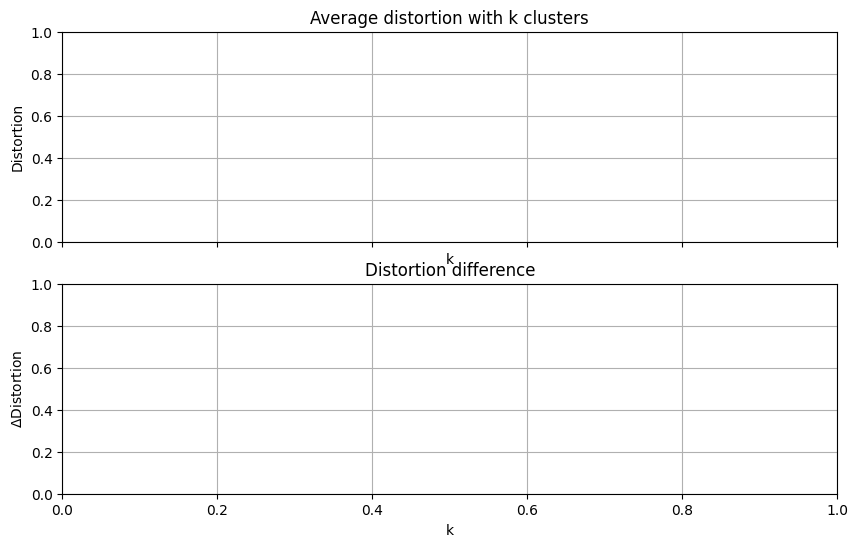

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(10, 6)


ax1.set_title("Average distortion with k clusters")
ax1.set_ylabel("Distortion")
ax1.set_xlabel("k")

ax2.set_title("Distortion difference")
ax2.set_ylabel("$\Delta$Distortion")
ax2.set_xlabel("k")

ax1.grid()
ax2.grid()

sns.scatterplot(x=map(lambda x: x[0], distortions), y=map(lambda x: x[1], distortions), ax=ax1)
distances = list(map(lambda t: t[1][1] - t[0][1], zip(distortions, distortions[1:])))
sns.lineplot(distances, ax=ax2)

plt.show()

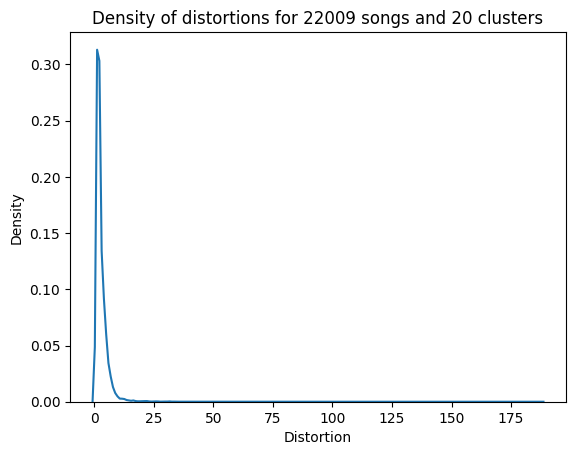

In [39]:
# Set k = 20 clusters, as we see a marginalized distortion difference from there
k = 20
codebook, _ =  scp.kmeans(normalized_observations, k)
assigned_clusters, obs_distortions = scp.vq(obs=normalized_observations, code_book=codebook)


sns.kdeplot(obs_distortions)
plt.title(f"Density of distortions for {len(obs_distortions)} songs and {k} clusters")
plt.xlabel("Distortion")
plt.show()

In [40]:
song_structure_df.head()

,amt_intro,pos_avg_intro,pos_std_intro,amt_verse,pos_avg_verse,pos_std_verse,amt_pre-chorus,pos_avg_pre-chorus,pos_std_pre-chorus,amt_chorus,...,pos_std_vamp,amt_break,pos_avg_break,pos_std_break,amt_solo,pos_avg_solo,pos_std_solo,amt_other,pos_avg_other,pos_std_other
song_id,,,,,,,,,,,,,,,,,,,,,
0,1,0.0,0.0,3,5.333333,4.189935,0,0.0,0.0,6,...,0.0,0,0.0,0.0,0,0.0,0.0,1,13.0,0.0
1,0,0.0,0.0,3,2.333333,2.054805,0,0.0,0.0,0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,1,0.0,0.0,3,2.666667,1.699673,0,0.0,0.0,2,...,0.0,1,3.0,0.0,0,0.0,0.0,0,0.0,0.0
4,0,0.0,0.0,2,1.000000,1.000000,0,0.0,0.0,0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
5,1,0.0,0.0,3,3.000000,1.632993,0,0.0,0.0,3,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [ ]:
# Assign the clusters to the dataframe and store them in the database

song_structure_df['cluster'] = assigned_clusters
song_cluster = [(int(song_id), int(cluster)) for song_id, cluster in song_structure_df[["cluster"]].to_records(index=True)]

conn, cursor = create_connection("genius_db")
cursor.executemany("INSERT INTO cluster (song_id, cluster_id) VALUES (%s,%s)", song_cluster)
conn.commit()
conn.close()

[(0, 13), (1, 12), (2, 15), (4, 1), (5, 10), (6, 10), (7, 10), (8, 13), (9, 7), (10, 7), (11, 7), (65, 10), (18284, 17), (18285, 4), (18286, 3), (18287, 12), (12, 3), (13, 8), (16, 8), (17, 15), (18, 12), (20, 8), (21, 15), (22, 15), (23, 1), (24, 1), (25, 7), (26, 3), (27, 7), (28, 10), (29, 8), (30, 13), (31, 10), (32, 4), (33, 3), (18288, 13), (18289, 10), (18291, 10), (18292, 10), (35, 13), (36, 6), (37, 9), (38, 1), (41, 10), (43, 14), (44, 13), (45, 10), (1715, 1), (1717, 10), (46, 7), (49, 13), (51, 1), (52, 9), (19107, 4), (57, 7), (59, 10), (61, 8), (62, 13), (63, 14), (66, 8), (70, 8), (71, 6), (74, 6), (77, 5), (79, 14), (81, 1), (82, 10), (332, 1), (83, 18), (86, 12), (88, 14), (89, 9), (91, 10), (982, 7), (983, 3), (18293, 14), (18294, 4), (97, 16), (98, 4), (101, 1), (102, 10), (103, 13), (105, 6), (106, 8), (107, 10), (108, 4), (110, 12), (111, 3), (113, 10), (1071, 9), (1072, 16), (1074, 4), (115, 19), (116, 5), (117, 13), (118, 16), (120, 14), (121, 8), (122, 1), (1097